In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

In [53]:
# Create training and test dataloaders

num_workers = 0
# how many samples per batch to load
batch_size = 64

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

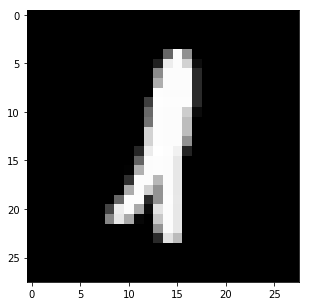

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [7]:
import torch.nn as nn
import torch.nn.functional as F
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
                
        return x

# initialize the NN
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [10]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [11]:
# number of epochs to train the model
n_epochs = 30

model = model.to(device)
for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        images = images.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

/home/dhruv/anaconda3/envs/torch/lib/python3.7/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 1.985869
Epoch: 2 	Training Loss: 1.324033
Epoch: 3 	Training Loss: 0.896275
Epoch: 4 	Training Loss: 0.837311
Epoch: 5 	Training Loss: 0.803999
Epoch: 6 	Training Loss: 0.783377
Epoch: 7 	Training Loss: 0.770408
Epoch: 8 	Training Loss: 0.760785
Epoch: 9 	Training Loss: 0.753524
Epoch: 10 	Training Loss: 0.746624
Epoch: 11 	Training Loss: 0.741291
Epoch: 12 	Training Loss: 0.736873
Epoch: 13 	Training Loss: 0.733463
Epoch: 14 	Training Loss: 0.730151
Epoch: 15 	Training Loss: 0.727363
Epoch: 16 	Training Loss: 0.725255
Epoch: 17 	Training Loss: 0.723336
Epoch: 18 	Training Loss: 0.721533
Epoch: 19 	Training Loss: 0.720076
Epoch: 20 	Training Loss: 0.718749
Epoch: 21 	Training Loss: 0.717495
Epoch: 22 	Training Loss: 0.716324
Epoch: 23 	Training Loss: 0.715534
Epoch: 24 	Training Loss: 0.714404
Epoch: 25 	Training Loss: 0.713473
Epoch: 26 	Training Loss: 0.712736
Epoch: 27 	Training Loss: 0.712156
Epoch: 28 	Training Loss: 0.711180
Epoch: 29 	Training Loss: 0.7

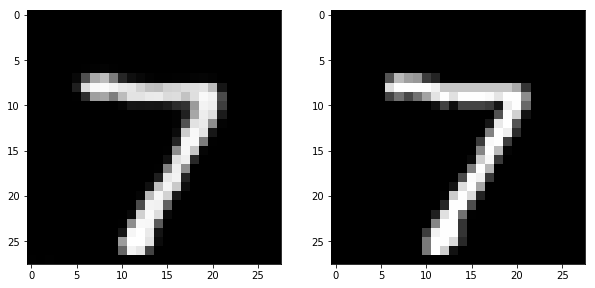

In [55]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.to(device)
# get sample outputs
output = model(images)
# prep images for display
images = images.cpu().numpy()
image=images[0]
# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output1 = output.cpu().detach().numpy()

# plot the first ten input images and then reconstructed images
plt.figure(figsize=(10,5))
# input images on top row, reconstructions on bottom
plt.subplot(121)
plt.imshow(np.squeeze(output1[0]), cmap='gray')

plt.subplot(122)
plt.imshow(np.squeeze(image), cmap='gray')

In [45]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 8), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        self.conv4 = nn.Conv2d(4, 16, 3, padding=1)
        self.conv5 = nn.Conv2d(16, 1, 3, padding=1)
        

    def forward(self, x):
        # add layer, with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decoder 
        # upsample, followed by a conv layer, with relu activation function  
        # this function is called `interpolate` in some PyTorch versions
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = F.relu(self.conv4(x))
        # upsample again, output should have a sigmoid applied
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = F.sigmoid(self.conv5(x))
        
        return x

# initialize the NN
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [46]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [47]:
# number of epochs to train the model
n_epochs = 30

model = model.to(device)
for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        images = images.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 1.363659
Epoch: 2 	Training Loss: 0.550821
Epoch: 3 	Training Loss: 0.492873
Epoch: 4 	Training Loss: 0.458555
Epoch: 5 	Training Loss: 0.435163
Epoch: 6 	Training Loss: 0.416663
Epoch: 7 	Training Loss: 0.402390
Epoch: 8 	Training Loss: 0.392082
Epoch: 9 	Training Loss: 0.383825
Epoch: 10 	Training Loss: 0.376757
Epoch: 11 	Training Loss: 0.370888
Epoch: 12 	Training Loss: 0.364645
Epoch: 13 	Training Loss: 0.359933
Epoch: 14 	Training Loss: 0.354973
Epoch: 15 	Training Loss: 0.350739
Epoch: 16 	Training Loss: 0.346683
Epoch: 17 	Training Loss: 0.343059
Epoch: 18 	Training Loss: 0.340072
Epoch: 19 	Training Loss: 0.337257
Epoch: 20 	Training Loss: 0.334599
Epoch: 21 	Training Loss: 0.332238
Epoch: 22 	Training Loss: 0.330092
Epoch: 23 	Training Loss: 0.328076
Epoch: 24 	Training Loss: 0.326038
Epoch: 25 	Training Loss: 0.324061
Epoch: 26 	Training Loss: 0.322494
Epoch: 27 	Training Loss: 0.320696
Epoch: 28 	Training Loss: 0.319027
Epoch: 29 	Training Loss: 0.3

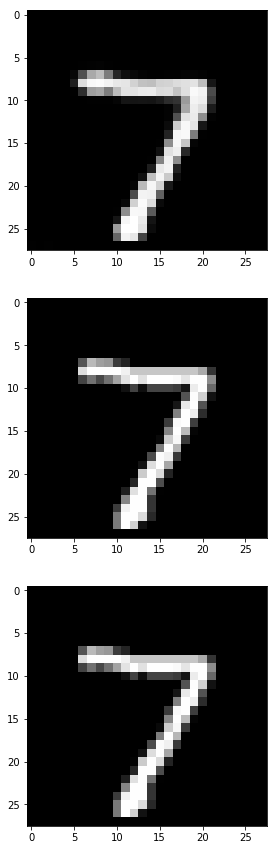

In [56]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.to(device)
# get sample outputs
output = model(images)
# prep images for display
images = images.cpu().numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()

# plot the first ten input images and then reconstructed images
plt.figure(figsize=(12,15))
# input images on top row, reconstructions on bottom
plt.subplot(311)
plt.imshow(np.squeeze(output[0]), cmap='gray')

plt.subplot(313)
plt.imshow(np.squeeze(images[0]), cmap='gray')

plt.subplot(312)
plt.imshow(np.squeeze(image),cmap='gray')